# Steel Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.odr import Model
from scipy.odr import RealData
from scipy.odr import ODR
from scipy.optimize import curve_fit

In [2]:
# Importing the Raw Data Files

data30degH2 = np.loadtxt('Data/Iron/30degIronDataHone2')
df30deg = data30degH2[:,0]
iv30deg = data30degH2[:,1]
ov30deg = data30degH2[:,2]

data60degH2 = np.loadtxt('Data/Iron/60degIronDataHone2.2')
df60deg = data60degH2[:,0]
iv60deg= data60degH2[:,1]
ov60deg = data60degH2[:,2]

data90degH2 = np.loadtxt('Data/Iron/90degIronDataHone2.2')
df90deg = data90degH2[:,0]
iv90deg= data90degH2[:,1]
ov90deg = data90degH2[:,2]

data120degH2 = np.loadtxt('Data/Iron/120degIronDataHone2')
df120deg = data120degH2[:,0]
iv120deg= data120degH2[:,1]
ov120deg = data120degH2[:,2]

data150degH2 = np.loadtxt('Data/Iron/150degIronDataHone2')
df150deg = data150degH2[:,0]
iv150deg= data150degH2[:,1]
ov150deg = data150degH2[:,2]

In [3]:
# Error for DAQ's DAC:

DACRes = 5 / 2**(12)
AbsoluteAccuracyofDAC = 7e-3 # In normal working conditions.
DACError = DACRes + (7e-3)
print(DACError)

# Resolution on the DAQ's ADC:

VoltageRange = 10 # As it was specified on the computer to work in this range
BitResolution = 12 # As i was using a NI USB 6008 which only has a 12 bit ADC

Resolution = VoltageRange/2**(BitResolution)

print('This is the smallest change in voltage the ADC can measure:',Resolution)

# This is equivalent to 2.44mV 

# Must add the absolute accuracy of the NI USB as well which accounts for all of the changes or errors in measurements due to Noise and temperature drift of the device.

AbsAccuracy = 4.38 * 10 **(-3) 

OVError = Resolution + AbsAccuracy
print('This is the total error of the Output Voltage measurements including everything:',OVError)

0.008220703125
This is the smallest change in voltage the ADC can measure: 0.00244140625
This is the total error of the Output Voltage measurements including everything: 0.00682140625


In [4]:
#  Creating a list the same size as the x vlaues as they all have the same errors

dferror = 0.75 # consistent for all measurements

df30degerr = [dferror] * len(df30deg)
df60degerr = [dferror] * len(df60deg)
df90degerr = [dferror] * len(df90deg)
df120degerr = [dferror] * len(df120deg)
df150degerr = [dferror] * len(df150deg)

## Modelling the Data using Orthogonal Distance Regression

In [5]:
# Modelling the data using a Lorentzian 
# Chose to pick a Lorentzian and use ODR as both of my measurements are independent for the x and y axis and have separate errors.
# Another Reason being that its peak is more sharp than a Gaussian which is what is seen with resonant Graphs

def Lorentzian(B, w):
    A, w0, deltaw, b = B
    return (A / ((w - w0)**2 + (1/2 * deltaw)**2)) + b

# A being the amplitude of the Lorentzian, w being omega the frequency and w0 being the resonant frequency,
# with deltaw being the full width at half maximum

Lorentzian_model = Model(Lorentzian)

# Here I am using Scipy to store the Function of the Lorentzian as a model, the Model part stores info about the function i want to fit which is the Lorentzian.

In [6]:
# Creating a for loop to sweep through and gather the parameters and errors for all temperatures quickly

# Putting all of my data into a list for the x and y axis
IronData_x_axis = [df30deg, df60deg, df90deg, df120deg, df150deg]
IronData_y_axis = [ov30deg, ov60deg, ov90deg, ov120deg, ov150deg]
IronData_errors = [df30degerr, df60degerr, df90degerr, df120degerr, df150degerr]
EstimatesofFMHW = [1.75, 1.1, 1, 1.2, 0.8] # Estimated using the individual plots of the data above
EstimatesofAmplitudes = [3, 2.5, 2.5, 3, 3] 
resonantfreqs = [2.715400000000000205e+02, 2.710199999999999818e+02 , 2.693299999999999841e+02, 2.681100000000000136e+02, 2.674700000000000273e+02] # Gottem from Raw data 
bguess = [2.416175186857216772e-03, 2.416175186857216772e-03, 5.849815481285958185e-02, 2.416175186857216772e-03, 2.416175186857216772e-03]

# Initialising all of the lists needed for later Calculations

w_fits = []
y_fits = []
w0 = []
deltaw = []
sw0 = []
sdeltaw = []
sdeltaww0 = []

for i, j, k, q, p, m, b in zip(IronData_x_axis, IronData_y_axis, IronData_errors, EstimatesofFMHW, EstimatesofAmplitudes, resonantfreqs, bguess):
    # Inputting all experimental data
    w = np.array(i) # Driver Frequencies
    y = np.array(j) # Output Voltages
    sw = np.array(k) # Consistent Fluctuation on frequency measurement
    sy = np.array(OVError) # Error on ADC in NI USB 6008

    data = RealData(w ,y, sx=sw, sy=sy) # Creating the RealData object as specified on the Scipy.ODR webpage with x, y values and their uncertainties.
    # Not including covariances here as the variables are independent.

    # Must guess initial parameters for the parameters in the vector B; A (amplitude), w0 (resonant frequency) and deltaw (Full width half maximum of graph)
    Initial_Estimate = [((p * (0.5 * q)**2)), m, q, b]

    # Instantiating the Blueprint ODR with my experimental data
    myodr = ODR(data, Lorentzian_model, beta0=Initial_Estimate)

    # Running the fit
    output = myodr.run()

    # Appending the values of w0 and deltaw for later calculations:
    w0.append(output.beta[1])

    deltaw.append(output.beta[2])

    # Appending the errors of the parameters above
    sw0.append(output.sd_beta[1])
    sdeltaw.append(output.sd_beta[2])

    #Appending the Covariance of deltaw and w0 for later calculations
    # sdeltaww0.append(output.cov_beta[1, 2])

    # Printing a summary of the fit results:
    # output.pprint()

    # Extract the optimal parameters:
    popt = output.beta # Gives optimized parameters A, w0 and deltaw
    perr = output.sd_beta # Gives the Standard deviation of the parameters (errors)

    # Creating 1000 equally spaced points on the x axis for the model just made
    w_fit = np.linspace(min(w), max(w), 1000)

    # Using the parameters from the ODR to create the theoretical model
    y_fit = Lorentzian(popt, w_fit)

    # Adding these fits to their own lists for later usage
    w_fits.append(w_fit)
    y_fits.append(y_fit)

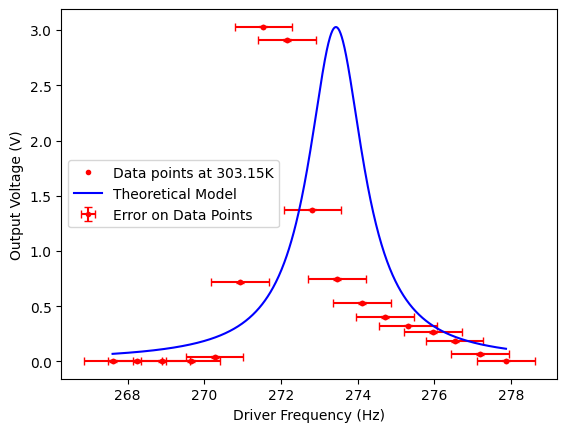

In [7]:
# Plotting the models

# Overlays
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

# Plotting the Data as Points
plt.plot(df30deg, ov30deg, '.', label = 'Data points at 303.15K', color = 'r')
plt.errorbar(df30deg, ov30deg, xerr=df30degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[0], y_fits[0], color = 'b', label='Theoretical Model')
plt.legend()
plt.savefig('303.15K-Steel-Graph.png')

plt.show()

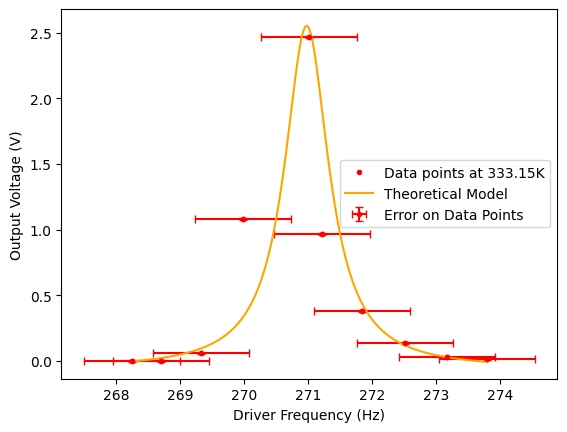

In [8]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df60deg, ov60deg, '.', label = 'Data points at 333.15K', color = 'r')
plt.errorbar(df60deg, ov60deg, xerr=df60degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[1], y_fits[1], color = 'orange', label='Theoretical Model')
plt.legend()
plt.savefig('333.15K-Steel-Graph.png')

plt.show()

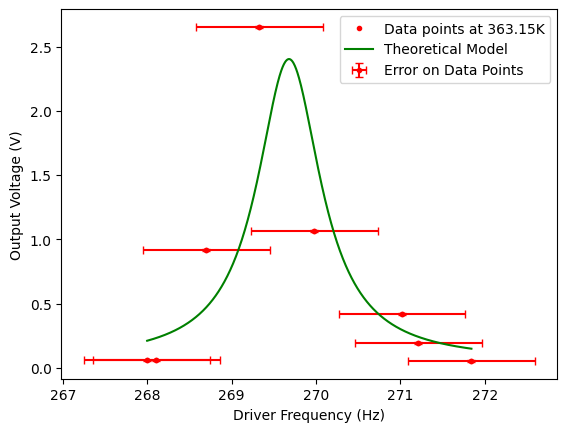

In [9]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df90deg, ov90deg, '.', label='Data points at 363.15K', color = 'r')
plt.errorbar(df90deg, ov90deg, xerr=df90degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[2], y_fits[2], color = 'g', label='Theoretical Model')
plt.legend()
plt.savefig('363.15K-Steel-Graph.png')

plt.show()


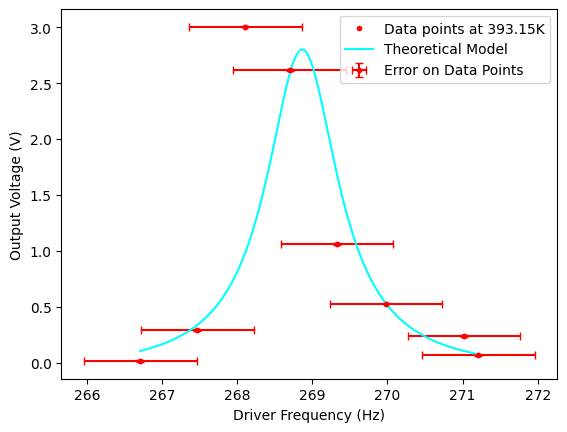

In [10]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df120deg, ov120deg, '.', label='Data points at 393.15K', color = 'r')
plt.errorbar(df120deg, ov120deg, xerr=df120degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[3], y_fits[3], color = 'cyan', label='Theoretical Model')
plt.legend()
plt.savefig('393.15K-Steel-Graph.png')

plt.show()


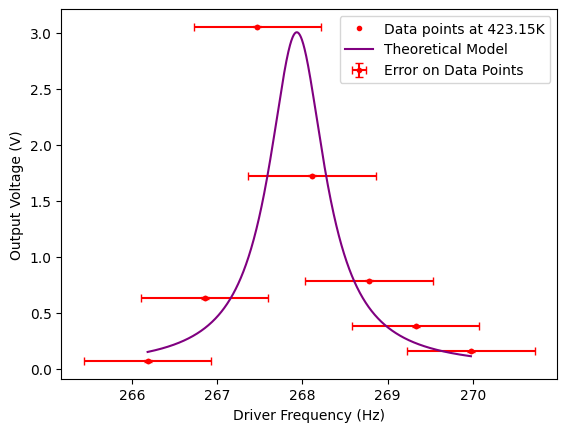

In [11]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df150deg, ov150deg, '.', label='Data points at 423.15K', color = 'r')
plt.errorbar(df150deg, ov150deg, xerr=df150degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[4], y_fits[4], color = 'purple', label='Theoretical Model')
plt.legend()
plt.savefig('423.15K-Steel-Graph.png')

plt.show()

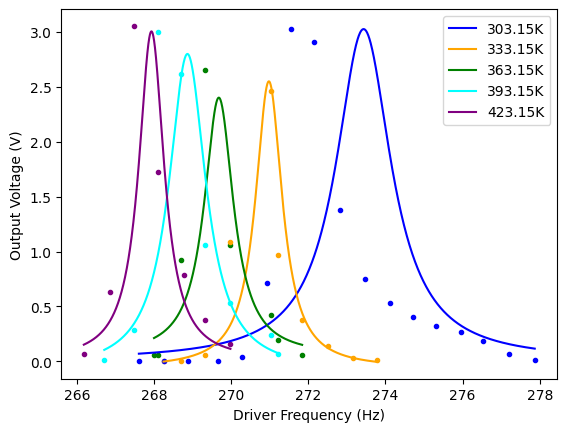

In [12]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df150deg, ov150deg, '.', color = 'purple')
plt.plot(df120deg, ov120deg, '.', color = 'cyan')
plt.plot(df90deg, ov90deg, '.', color = 'g')
plt.plot(df60deg, ov60deg, '.', color = 'orange')
plt.plot(df30deg, ov30deg, '.', color = 'b')

plt.plot(w_fits[0], y_fits[0], color = 'b', label = '303.15K')
plt.plot(w_fits[1], y_fits[1], color = 'orange', label = '333.15K')
plt.plot(w_fits[2], y_fits[2], color = 'g', label='363.15K')
plt.plot(w_fits[3], y_fits[3], color = 'cyan', label='393.15K')
plt.plot(w_fits[4], y_fits[4], color = 'purple', label='423.15K')
plt.legend()
plt.savefig('All-Steel-RGraphs.png')

plt.show()

### Calculating G and Q

In [13]:
def MORG(I, l, w0, r):
    return (2 * I * l * ((w0 * 2 * np.pi)**(2))) / (np.pi * (r ** 4))

def MomentOfInertia(m, r): # Done 
    return (1/2) * m * (r ** 2)

def MomentOfInertiaError(m, r, sm, sr): # Done 
    return np.sqrt(((0.5*r**2)**2) * (sm ** 2) + ((1.0*m*r)**2) * (sr ** 2))

def MORGError(I, l, w0, r, sI, sl, sw0, sr):
    return np.sqrt(
        (((0.636619772367581 * l * ((w0 * 2 * np.pi) ** 2)) / (r ** 4)) ** 2) * (sI ** 2) +
        (((0.636619772367581 * I * ((w0 * 2 * np.pi) ** 2)) / (r ** 4)) ** 2) * (sl ** 2) +
        ((1.27323954473516 * I * l * ((w0 * 2 * np.pi)) / (r ** 4)) ** 2) * ((sw0 * 2 * np.pi) ** 2) +
        (((-2.54647908947033 * I * l * ((w0 * 2 * np.pi) ** 2)) / (r ** 5)) ** 2) * (sr ** 2)
    )

def IFQ(deltaw, w0):
    return (np.sqrt(3) * (w0 * 2 * np.pi)) / (deltaw * 2 * np.pi) 

def IFQError(w0, deltaw, sw0, sdeltaw):
    return np.sqrt(
        (((1.73205080756888 / (deltaw * 2 * np.pi)) ** 2) * ((sw0 * 2 * np.pi) ** 2)) +
        ((-1.73205080756888 * w0 * 2 * np.pi ) / ((deltaw * 2 * np.pi) ** 2)) ** 2 * ((sdeltaw * 2 * np.pi) ** 2)
        )

In [14]:
# Defining the measured parameters and their errors for each rod to sweep through the functions:

# Taking five measurements at different points along the wire
dsilver = [2.45, 2.44, 2.46, 2.44, 2.44]
dIron = [2.48, 2.47, 2.48, 2.48, 2.48]
dbrass = [2.48, 2.47, 2.48, 2.48, 2.47]

measuredrsilver = np.mean(dsilver) / 2000 # Going from mm to m
measuredriron = np.mean(dIron) / 2000 # Going from mm to m
measuredrbrass = np.mean(dbrass) / 2000 # Going from mm to m

# Going from Silver, Iron to Brass

m = [(7.44/1000), (22.24/1000), (23.58/1000)]
sm = (0.005/1000)

r = [measuredrsilver, measuredriron, measuredrbrass]
sr = (0.005/1000)

l = [(353/1000), (350/1000), (353/1000)]
sl = (0.5/1000)

I_rod = [MomentOfInertia(m[0], r[0]), MomentOfInertia(m[1], r[1]), MomentOfInertia(m[2], r[2])]
sI_rod = [MomentOfInertiaError(m[0], r[0], sm, sr), MomentOfInertiaError(m[1], r[1], sm, sr), MomentOfInertiaError(m[2], r[2], sm, sr)]

I_aux = MomentOfInertia((54.54/1000), (8.70/2000))
sI_aux = MomentOfInertiaError((54.54/1000), (8.70/2000), sm, sr)

# Summing the errors together to get the total error.
sI = [np.sqrt((sI_rod[0] ** 2) + (sI_aux ** 2)), np.sqrt((sI_rod[1] ** 2) + (sI_aux ** 2)), np.sqrt((sI_rod[2] ** 2) + (sI_aux ** 2))]

# Creating a list of all of the moments of inertia
I = [I_rod[0] + I_aux, I_rod[1] + I_aux, I_rod[2] + I_aux]

In [15]:
# Getting the values for the Modulus of rigidy for Aluminium:

G = [MORG(I[0], l[0], w0[0], r[0]), MORG(I[0], l[0], w0[1], r[0]),
     MORG(I[0], l[0], w0[2], r[0]), MORG(I[0], l[0], w0[3], r[0]),
     MORG(I[0], l[0], w0[4], r[0])]

sG = [MORGError(I[0], l[0], w0[0], r[0], sI[0], sl, sw0[0], sr), MORGError(I[0], l[0], w0[1], r[0], sI[0], sl, sw0[1], sr),
      MORGError(I[0], l[0], w0[2], r[0], sI[0], sl, sw0[2], sr), MORGError(I[0], l[0], w0[3], r[0], sI[0], sl, sw0[3], sr),
      MORGError(I[0], l[0], w0[4], r[0], sI[0], sl, sw0[4], sr)]

Q = [IFQ(deltaw[0], w0[0]), IFQ(deltaw[1], w0[1]), IFQ(deltaw[2], w0[2]),
     IFQ(deltaw[3], w0[3]), IFQ(deltaw[4], w0[4])]

sQ = [IFQError(w0[0], deltaw[0], sw0[0], sdeltaw[0]), IFQError(w0[1], deltaw[1], sw0[1], sdeltaw[1]),
      IFQError(w0[2], deltaw[2], sw0[2], sdeltaw[2]), IFQError(w0[3], deltaw[3], sw0[3], sdeltaw[3]),
      IFQError(w0[4], deltaw[4], sw0[4], sdeltaw[4])]

G = np.array(G)
print(G/1e9)
sG = np.array(sG)
print(sG/1e9)

Q = np.array(Q)
print(1/Q)
sQ = np.array(sQ)
print(1/sQ)

[154.64402559 151.8786408  150.42747182 149.52097324 148.48532325]
[2.96063718 2.52087115 6.75547153 6.14365401 3.14613102]
[0.00368011 0.00179638 0.00196497 0.00250697 0.00172292]
[0.00513743 0.00633838 0.00034315 0.00036105 0.00057017]


In [16]:
# performing ODR for the above data set

temp = np.array([303.15, 333.15, 363.15, 393.15, 423.15])
y_values = np.array(G) 

# Errors on temperature in degrees
randomfluctuationsofheatbox = 1 
resolutionuncertaintyofheatbox = 0.5

#sT = np.sqrt(((1)**2) + ((0.5)**2))
sT = [np.sqrt(((1)**2) + ((0.5)**2))] * len(temp)
sT_array = np.array(sT)

sG_array = np.array(sG)

In [17]:
# Using ODR to plot the line of best fit:

def LinearApproximation(B, x):
    m, c = B
    return m * x + c

linear = Model(LinearApproximation)

Beta: [-4.81685938e+07  1.68543203e+11]
Beta Std Error: [7.14021015e+06 2.53438330e+09]
Beta Covariance: [[ 1.12752159e+15 -3.96846176e+17]
 [-3.96846176e+17  1.42052040e+20]]
Residual Variance: 0.045216518450573916
Inverse Condition #: 0.00796077162692201
Reason(s) for Halting:
  Sum of squares convergence


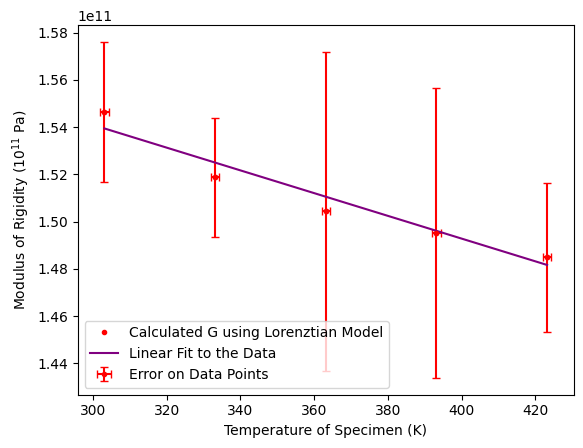

In [18]:
# Creating another ODR model to model the G trend

mydataG = RealData(temp, y_values, sx=sT_array, sy=sG_array)

EstimateofSlopeforG = (y_values[3] - y_values[2]) / (temp[3] - temp[2])

myodrG = ODR(mydataG, linear, beta0=[EstimateofSlopeforG, (1.65e11)])

myoutputG = myodrG.run()

myoutputG.pprint()

temp_fit = np.linspace(min(temp), max(temp), 1000)
G_fit = LinearApproximation(myoutputG.beta, temp_fit)

# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Modulus of Rigidity ($10^{11}$ Pa)')

plt.plot(temp, G, '.', label='Calculated G using Lorenztian Model', color = 'r')
plt.errorbar(temp, G, xerr=sT, yerr=sG, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(temp_fit, G_fit, color = 'purple', label='Linear Fit to the Data')

plt.legend()
plt.savefig('GvsTSteel.png')
plt.show()

In [19]:
# Exponential ODR

def exponential_model(beta, x):
    a, b = beta  
    return a * np.exp(b * x)

Exponential = Model(exponential_model)

mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)  

myodrQ = ODR(mydataQ, Exponential, beta0=[-1, 0.01]) 

myoutputQ = myodrQ.run()

myoutputQ.pprint()

Q_fit2 = exponential_model(myoutputQ.beta, temp_fit) 

Beta: [1.71729839e+01 1.00865133e-02]
Beta Std Error: [2.85169605e+01 5.03025566e-03]
Beta Covariance: [[ 4.36888580e+03 -7.68788770e-01]
 [-7.68788770e-01  1.35939084e-04]]
Residual Variance: 0.18613831452747953
Inverse Condition #: 0.001205663084825228
Reason(s) for Halting:
  Sum of squares convergence


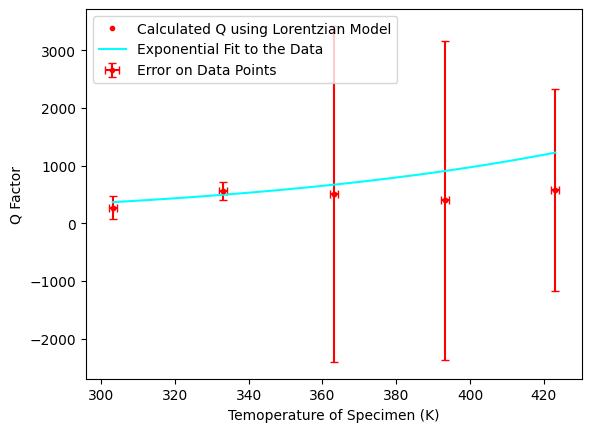

In [20]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temoperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Lorentzian Model', color = 'r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.legend()
plt.savefig('QvsTSteel.png')
plt.show()

In [21]:
# Code for ODR on the data for Q

EstimateofSlope = (Q[3] - Q[2]) / (temp[3] - temp[2])

mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)

myodrQ = ODR(mydataQ, linear, beta0=[EstimateofSlope, 0])

myoutputQ = myodrQ.run()

myoutputQ.pprint()

temp_fit = np.linspace(min(temp), max(temp), 1000)
Q_fit = LinearApproximation(myoutputQ.beta, temp_fit)

Beta: [    7.57166508 -1993.42386071]
Beta Std Error: [  2.05685602 663.1090114 ]
Beta Covariance: [[ 5.39294406e+01 -1.73631197e+04]
 [-1.73631197e+04  5.60515971e+06]]
Residual Variance: 0.0784479985580926
Inverse Condition #: 1.6004297462544472e-05
Reason(s) for Halting:
  Sum of squares convergence


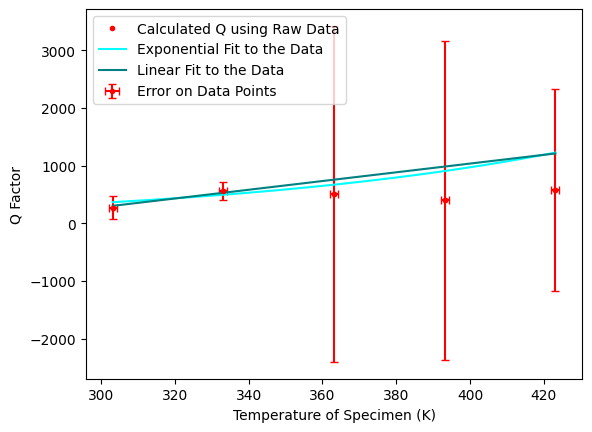

In [22]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
plt.legend()
plt.savefig('QvsTSteelLin.png')
plt.show()

## Calculating G and Q from the Raw Data

In [23]:
raww0Hz = resonantfreqs = [2.715400000000000205e+02, 2.710199999999999818e+02 , 2.693299999999999841e+02, 2.681100000000000136e+02, 2.674700000000000273e+02] # Gottem from Raw data 
rawdeltaw = EstimatesofFMHW = [1.75, 1.1, 1, 1.2, 0.8] # Estimated using the individual plots of the data above
sw0Hz = 0.75
sdeltawraw = 0.5 # from eyeball estimates

In [24]:
def IFQError2(w0, deltaw, sw0, sdeltaw):
    return np.sqrt(
        (((0.577350269189626 / (deltaw * 2 * np.pi)) ** 2) * ((sw0 * 2 * np.pi) ** 2)) +
        ((-0.577350269189626 * w0 * 2 * np.pi ) / ((deltaw * 2 * np.pi) ** 2)) ** 2 * ((sdeltaw * 2 * np.pi) ** 2)
        )

In [25]:
G = [MORG(I[0], l[0], raww0Hz[0], r[0]), MORG(I[0], l[0], raww0Hz[1], r[0]),
     MORG(I[0], l[0], raww0Hz[2], r[0]), MORG(I[0], l[0], raww0Hz[3], r[0]),
     MORG(I[0], l[0], raww0Hz[4], r[0])]

sG = [MORGError(I[0], l[0], raww0Hz[0], r[0], sI[0], sl, sw0Hz, sr), MORGError(I[0], l[0], raww0Hz[1], r[0], sI[0], sl, sw0Hz, sr),
      MORGError(I[0], l[0], raww0Hz[2], r[0], sI[0], sl, sw0Hz, sr), MORGError(I[0], l[0], raww0Hz[3], r[0], sI[0], sl, sw0Hz, sr),
      MORGError(I[0], l[0], raww0Hz[4], r[0], sI[0], sl, sw0Hz, sr)]

Q = [IFQ(rawdeltaw[0], raww0Hz[0]), IFQ(rawdeltaw[1], raww0Hz[1]), IFQ(rawdeltaw[2], raww0Hz[2]),
     IFQ(rawdeltaw[3], raww0Hz[3]), IFQ(rawdeltaw[4], raww0Hz[4])]

sQ = [IFQError2(raww0Hz[0], rawdeltaw[0], sw0Hz, sdeltawraw), IFQError2(raww0Hz[1], rawdeltaw[1], sw0Hz, sdeltawraw),
      IFQError2(raww0Hz[2], rawdeltaw[2], sw0Hz, sdeltawraw), IFQError2(raww0Hz[3], rawdeltaw[3], sw0Hz, sdeltawraw),
      IFQError2(raww0Hz[4], rawdeltaw[4], sw0Hz, sdeltawraw)]

G = np.array(G)
print(G/1e9)
sG = np.array(sG)
print(sG/1e9)

Q = np.array(Q)
print(1/Q)
sQ = np.array(sQ)
print(1/sQ)

print(np.mean(G/1e9))
print(np.mean(sG/1e9))
print(np.mean(Q))
print(np.mean(sQ))

[152.50984026 151.92628585 150.03745921 148.68127072 147.97228977]
[2.66407215 2.65438816 2.62304271 2.60053584 2.58876959]
[0.00372086 0.00234332 0.00214365 0.00258409 0.00172685]
[0.03906723 0.01546559 0.01286172 0.01860503 0.00828879]
150.22542916419388
2.6261616875784073
425.61339208936823
68.48008362545141


In [26]:
temp = np.array([303.15, 333.15, 363.15, 393.15, 423.15])
y_vals = G

# performing ODR for the above data set

# Errors on temperature in degrees
randomfluctuationsofheatbox = 1 
resolutionuncertaintyofheatbox = 0.5

#sT = np.sqrt(((1)**2) + ((0.5)**2))
sT = [np.sqrt(((1)**2) + ((0.5)**2))] * len(temp)
sT_array = np.array(sT)

sG_array = np.array(sG)

# Using ODR to plot the line of best fit:

def LinearApproximation(B, x):
    m, c = B
    return m * x + c

EstimateofSlope = (G[3] - G[2]) / (temp[3] - temp[2])

linear = Model(LinearApproximation)

mydata = RealData(G, temp, sx=sT, sy=sG)

myodr = ODR(mydata, linear, beta0=[EstimateofSlope, 2])

myoutput2 = myodr.run()

myoutput2.pprint()

slope, intercept = myoutput2.beta  # Optimal parameters
slope_error, intercept_error = myoutput2.sd_beta  # Errors in the parameters

Beta: [2.40729576e-09 2.00000000e+00]
Beta Std Error: [1.55169441e-10 0.00000000e+00]
Beta Covariance: [[6.11211717e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 3.939315080714142e-16
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Parameter convergence


In [27]:
# Creating another ODR model to model the G trend

mydataG = RealData(temp, y_vals, sx=sT_array, sy=sG_array)

EstimateofSlopeforG = (y_vals[3] - y_vals[2]) / (temp[3] - temp[2])

myodrG = ODR(mydataG, linear, beta0=[EstimateofSlopeforG, (1.65e11)])

myoutputG = myodrG.run()

myoutputG.pprint()

Beta: [-4.10473453e+07  1.65130688e+11]
Beta Std Error: [3.97758884e+06 1.45796807e+09]
Beta Covariance: [[ 7.66750120e+14 -2.79161199e+17]
 [-2.79161199e+17  1.03017285e+20]]
Residual Variance: 0.02063411870192069
Inverse Condition #: 0.010676566365299334
Reason(s) for Halting:
  Sum of squares convergence


In [28]:
temp_fit = np.linspace(min(temp), max(temp), 1000)
G_fit = LinearApproximation(myoutputG.beta, temp_fit)

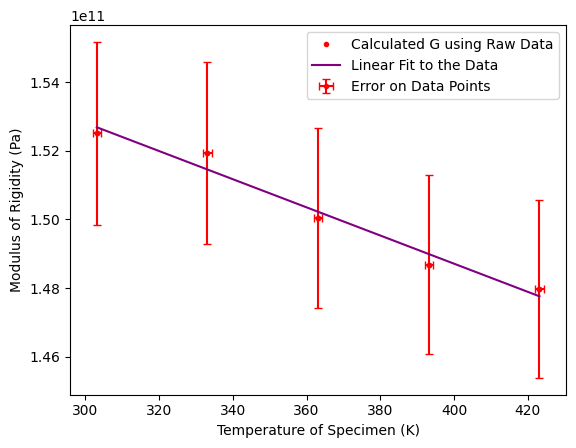

In [29]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Modulus of Rigidity (Pa)')

plt.plot(temp, G, '.', label='Calculated G using Raw Data', color = 'r')
plt.errorbar(temp, G, xerr=sT, yerr=sG, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(temp_fit, G_fit, color = 'purple', label='Linear Fit to the Data')

plt.legend()
plt.savefig('GvsTSteelRawData.png')
plt.show()

In [30]:
# Code for ODR on the data for Q

EstimateofSlope = (Q[3] - Q[2]) / (temp[3] - temp[2])

mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)

myodrQ = ODR(mydataQ, linear, beta0=[EstimateofSlope, 0])

myoutputQ = myodrQ.run()

myoutputQ.pprint()

temp_fit = np.linspace(min(temp), max(temp), 1000)
Q_fit = LinearApproximation(myoutputQ.beta, temp_fit)

Beta: [   1.89415518 -294.44121459]
Beta Std Error: [  0.69937673 230.38121426]
Beta Covariance: [[ 3.09067173e-01 -1.01157300e+02]
 [-1.01157300e+02  3.35370342e+04]]
Residual Variance: 1.582593846002062
Inverse Condition #: 3.430034535851072e-05
Reason(s) for Halting:
  Sum of squares convergence


In [31]:
# Exponential ODR

def exponential_model(beta, x):
    a, b = beta  
    return a * np.exp(b * x)

Exponential = Model(exponential_model)

mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)  

myodrQ = ODR(mydataQ, Exponential, beta0=[-1, 0.01]) 

myoutputQ = myodrQ.run()

myoutputQ.pprint()

Q_fit2 = exponential_model(myoutputQ.beta, temp_fit) 

Beta: [6.14367101e+01 5.03892952e-03]
Beta Std Error: [3.97288997e+01 1.86419125e-03]
Beta Covariance: [[ 9.15508445e+02 -4.26147224e-02]
 [-4.26147224e-02  2.01572002e-06]]
Residual Variance: 1.7240534275445751
Inverse Condition #: 0.0005898029347372285
Reason(s) for Halting:
  Sum of squares convergence


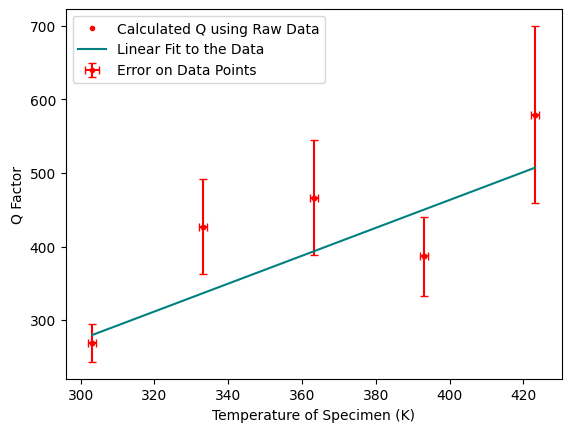

In [32]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
plt.legend()
plt.savefig('QvsTSteelRawDataLin.png')
plt.show()

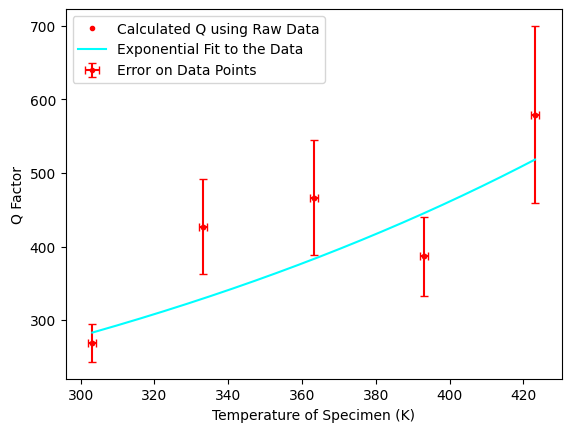

In [33]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.legend()
plt.savefig('QvsTSteelRawDataExp.png')
plt.show()

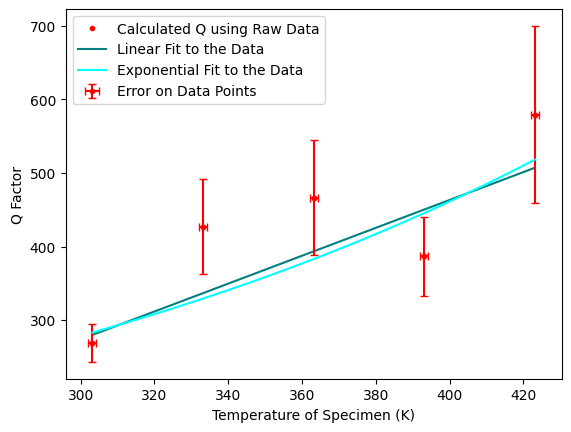

In [34]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.legend()
plt.savefig('QvsTSteelRawDatabothcurves.png')
plt.show()